In [83]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

In [84]:
from useful_functions import synthetic_control_weights, plot_synthetic_weights, placebo_test, mspe, plot_mspe_ratio

## Joesley Day

In [85]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-02-16':'2017-05-23', :]

df_norm = df.pct_change().dropna()

print(df_norm.shape)

(66, 44)


In [86]:
# Define intervention date
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

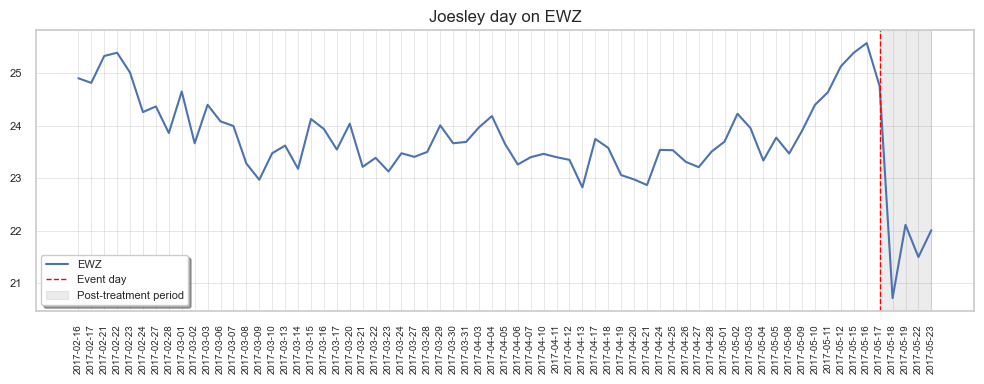

In [ ]:
# Plot chart
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df['EWZ'], label='EWZ')

plt.axvline(treatment_date, color="red", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Joesley day on EWZ")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [88]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[treated.index < treatment_date].values
Y0_pre = donors[donors.index < treatment_date].values
print(Y0_pre.shape, Y0_pre.shape)

(61, 43) (61, 43)


### Canonical Synthetic Control
Compute donor weights for Synthetic Control following Abadie's restrictions
* weights are all positive
* weights add up to one

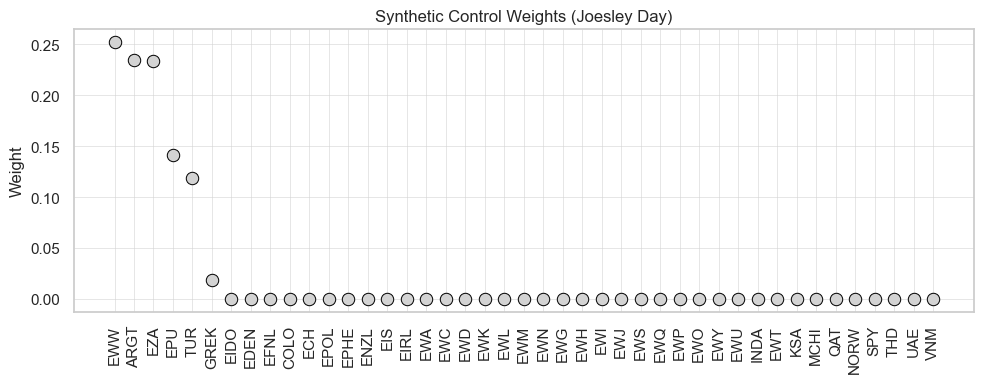

In [89]:
# Calculate weights
weights = synthetic_control_weights(Y1_pre, Y0_pre)

# Apply weights
EWZ_synth_canon = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Joesley Day)',
    figsize=(10,4)
)

### OLS method

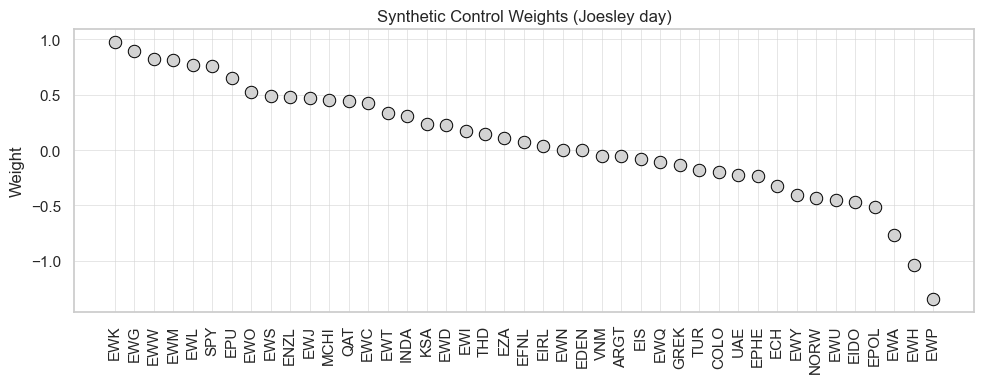

In [90]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params

# Apply weights
EWZ_synth_ols = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Joesley day)',
    figsize=(10,4)
)

### Results

In [91]:
treated_pre = treated[treated.index < treatment_date]
treated_post = treated[treated.index >= treatment_date]

synth_pre_canon = EWZ_synth_canon[EWZ_synth_canon.index < treatment_date]
synth_post_canon = EWZ_synth_canon[EWZ_synth_canon.index >= treatment_date]

synth_pre_ols = EWZ_synth_ols[EWZ_synth_ols.index < treatment_date]
synth_post_ols = EWZ_synth_ols[EWZ_synth_ols.index >= treatment_date]

In [92]:
print(mspe(treated_pre, synth_pre_canon))
print(mspe(treated_pre, synth_post_ols))
print(mspe(treated_post, synth_post_canon))
print(mspe(treated_post, synth_post_ols))

0.0001337761228579827
nan
0.0048518600524575075
0.005346878228142356


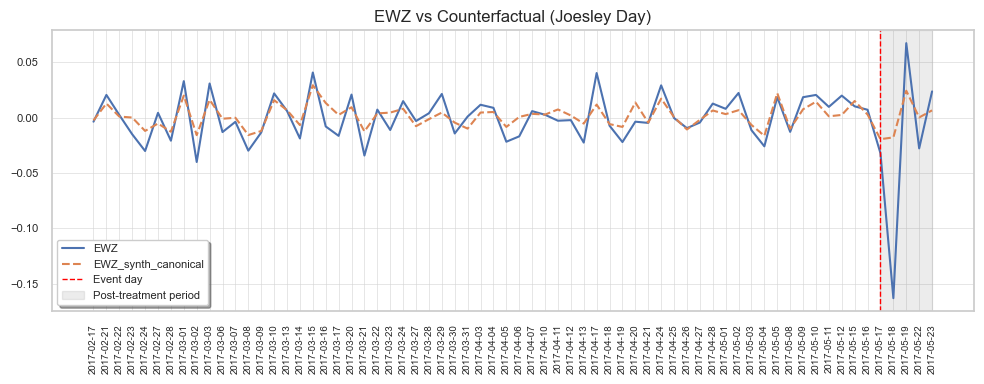

In [93]:
# Plot treated and counterfactual
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df_norm.index, treated, label='EWZ')
plt.plot(df_norm.index, EWZ_synth_canon, linestyle="--", label='EWZ_synth_canonical')
#plt.plot(df_norm.index, EWZ_synth_ols, linestyle="--", label='EWZ_synth_ols')

plt.axvline(t0, color="red", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("EWZ vs Counterfactual (Joesley Day)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

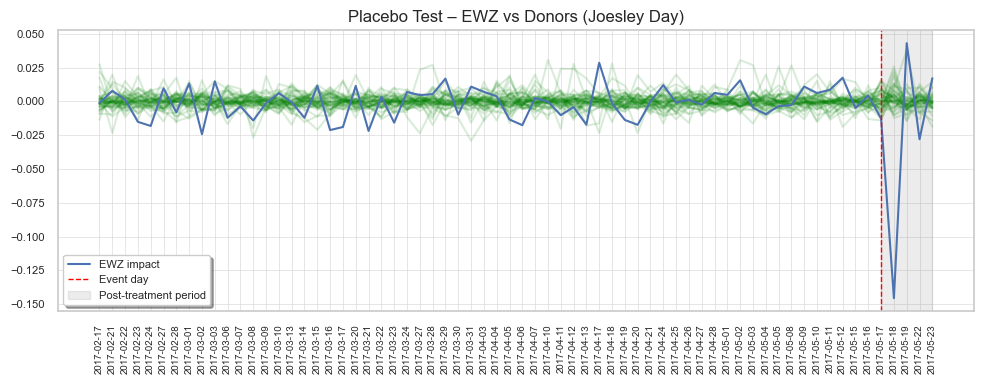

In [94]:
# Placebo test
placebo_gap = placebo_test(df_norm, treatment_date) # canonical method
#placebo_gap = placebo_test(df_norm, treatment_date, weight_calculus='ols') # ols method

treated_gap = placebo_gap['EWZ']
placebo_gap.pop("EWZ")

# Plot
plt.figure(figsize=(10,4))
for k in placebo_gap:
    plt.plot(placebo_gap[k].index, placebo_gap[k].values, color="green", alpha=0.15)
plt.plot(df_norm.index, treated_gap, label='EWZ impact')

plt.axvline(t0, color="red", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Placebo Test – EWZ vs Donors (Joesley Day)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [95]:
# 1 day after de news
day_1_effect = float(treated_gap['2017-05-18'])
day_1_effect

-0.14548341283831065

In [96]:
# MSPE pre-treatment
mspe_treated_pre = float(np.mean(treated_gap[:t0]**2))
mspe_placebo_pre = {k: float(np.mean((placebo_gap[k][:t0].values)**2)) for k in placebo_gap}

# MSPE post-treatment
mspe_treated_post = float(np.mean(treated_gap[t0:]**2))
mspe_placebo_post = {k: float(np.mean((placebo_gap[k][t0:].values)**2)) for k in placebo_gap}

# MSPE ratio
mspe_ratio_treated = mspe_treated_post / mspe_treated_pre
mspe_ratio_placebo = [mspe_placebo_post[i] / mspe_placebo_pre[i] for i in mspe_placebo_pre]

# p-value
p_value = np.mean(mspe_ratio_placebo >= np.array(mspe_ratio_treated))
print(f"p-value: {p_value}")

p-value: 0.0


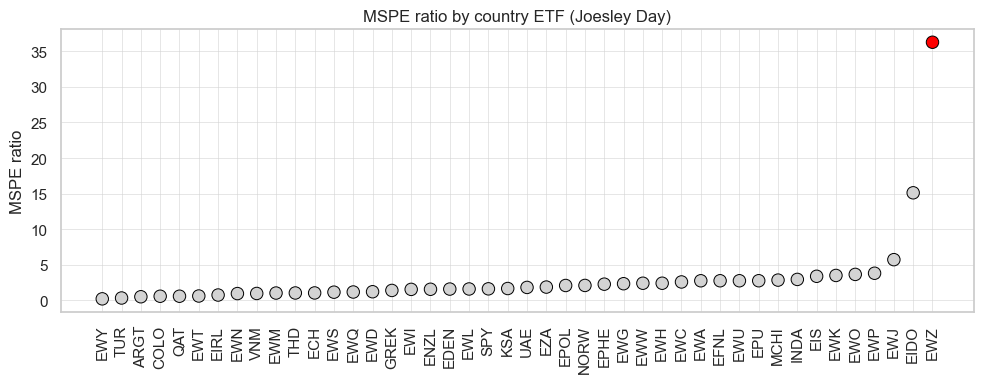

In [97]:
# Plot MSPE
mspe_plot = pd.DataFrame(
    {'mspe_ratio': mspe_ratio_placebo},
    index=mspe_placebo_pre.keys()
)
mspe_plot.loc['EWZ'] = mspe_ratio_treated
mspe_plot.sort_values('mspe_ratio', inplace=True)

plot_mspe_ratio(mspe_plot, treated_label='EWZ', title="MSPE ratio by country ETF (Joesley Day)", figsize=(10,4))

## Covid-19

In [98]:
df = pd.read_csv("covid.csv", index_col=['Date'])
df = df.loc['2019-11-18':'2020-03-23', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()
print(df_norm.shape)

(85, 44)


In [99]:
# Define intervention date
treatment_date = "2020-02-20"
t0 = df_norm.index.get_loc(treatment_date)

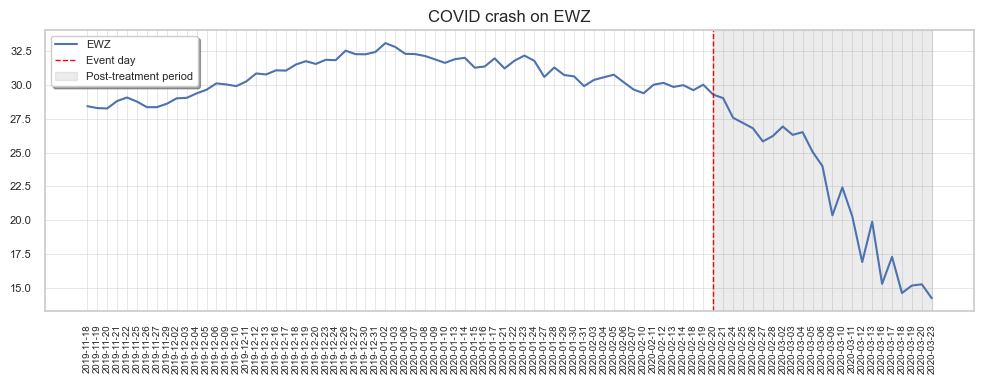

In [100]:
# Plot treated and counterfactual
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df['EWZ'], label='EWZ')

plt.axvline(treatment_date, color="red", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("COVID crash on EWZ")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [101]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[treated.index < treatment_date].values
Y0_pre = donors[donors.index < treatment_date].values
print(Y0_pre.shape, Y0_pre.shape)

(62, 43) (62, 43)


### Canonical Synthetic Control
Compute donor weights for Synthetic Control following Abadie's restrictions
* weights are all positive
* weights add up to one

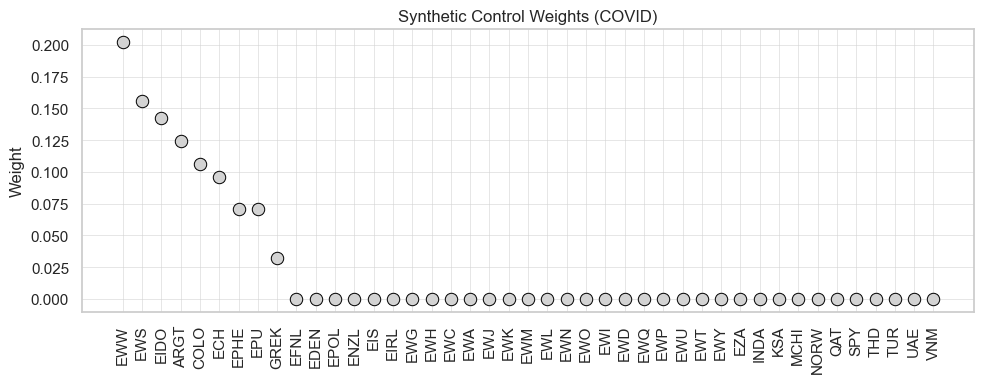

In [102]:
# Calculate weights
weights = synthetic_control_weights(Y1_pre, Y0_pre)

# Apply weights
EWZ_synth_canon = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (COVID)',
    figsize=(10,4)
)

### OLS method

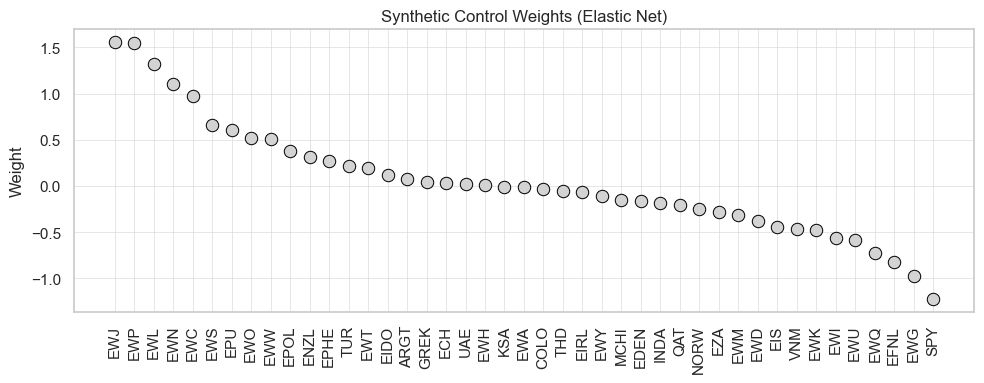

In [103]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params

# Apply weights
EWZ_synth_ols = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Elastic Net)',
    figsize=(10,4)
)

### Results

In [104]:
treated_pre = treated[treated.index < treatment_date]
treated_post = treated[treated.index >= treatment_date]

synth_pre_canon = EWZ_synth_canon[EWZ_synth_canon.index < treatment_date]
synth_post_canon = EWZ_synth_canon[EWZ_synth_canon.index >= treatment_date]

synth_pre_ols = EWZ_synth_ols[EWZ_synth_ols.index < treatment_date]
synth_post_ols = EWZ_synth_ols[EWZ_synth_ols.index >= treatment_date]

In [105]:
print(mspe(treated_pre, synth_pre_canon))
print(mspe(treated_pre, synth_post_ols))
print(mspe(treated_post, synth_post_canon))
print(mspe(treated_post, synth_post_ols))

8.339834817521008e-05
nan
0.0022510909534734446
0.002252837766407044


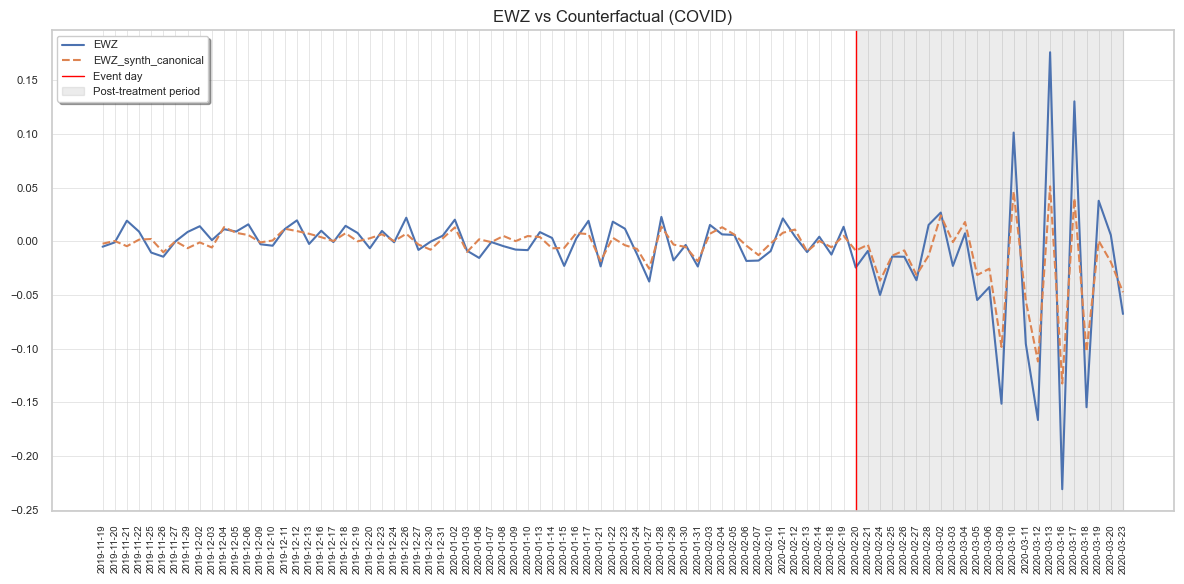

In [110]:
# Plot treated and counterfactual
sns.set_theme(style="whitegrid")
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(12, 6))

plt.plot(df_norm.index, treated, label='EWZ')
plt.plot(df_norm.index, EWZ_synth_canon, linestyle="--", label='EWZ_synth_canonical')
#plt.plot(df_norm.index, EWZ_synth_ols, linestyle="--", label='EWZ_synth_ols')

plt.axvline(t0, color="red", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("EWZ vs Counterfactual (COVID)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

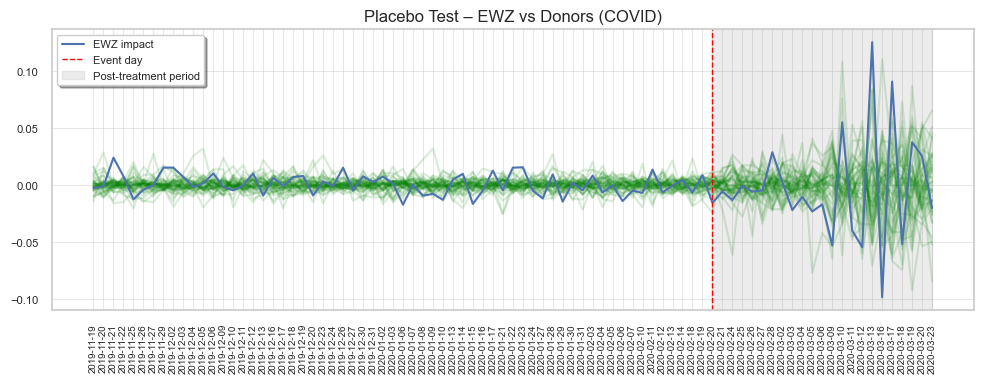

In [111]:
# Placebo test
placebo_gap = placebo_test(df_norm, treatment_date) # canonical method
#placebo_gap = placebo_test(df_norm, treatment_date, weight_calculus='ols') # ols method

treated_gap = placebo_gap['EWZ']
placebo_gap.pop("EWZ")

# Plot
plt.figure(figsize=(10,4))
for k in placebo_gap:
    plt.plot(placebo_gap[k].index, placebo_gap[k].values, color="green", alpha=0.15)
plt.plot(df_norm.index, treated_gap, label='EWZ impact')

plt.axvline(t0, color="red", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Placebo Test – EWZ vs Donors (COVID)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [108]:
# MSPE pre-treatment
mspe_treated_pre = float(np.mean(treated_gap[:t0]**2))
mspe_placebo_pre = {k: float(np.mean((placebo_gap[k][:t0].values)**2)) for k in placebo_gap}

# MSPE post-treatment
mspe_treated_post = float(np.mean(treated_gap[t0:]**2))
mspe_placebo_post = {k: float(np.mean((placebo_gap[k][t0:].values)**2)) for k in placebo_gap}

# MSPE ratio
mspe_ratio_treated = mspe_treated_post / mspe_treated_pre
mspe_ratio_placebo = [mspe_placebo_post[i] / mspe_placebo_pre[i] for i in mspe_placebo_pre]

# p-value
p_value = np.mean(mspe_ratio_placebo >= np.array(mspe_ratio_treated))
print(f"p-value: {p_value}")

p-value: 0.20930232558139536


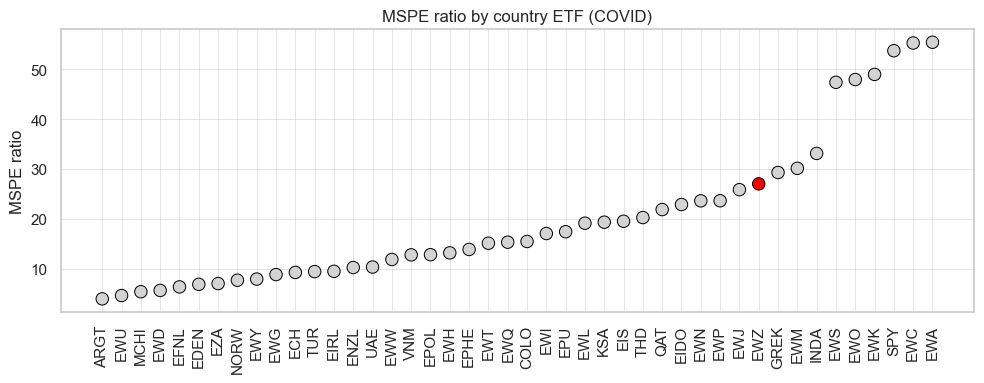

In [109]:
# Plot MSPE
mspe_plot = pd.DataFrame(
    {'mspe_ratio': mspe_ratio_placebo},
    index=mspe_placebo_pre.keys()
)
mspe_plot.loc['EWZ'] = mspe_ratio_treated
mspe_plot.sort_values('mspe_ratio', inplace=True)

plot_mspe_ratio(mspe_plot, treated_label='EWZ', title="MSPE ratio by country ETF (COVID)", figsize=(10,4))

-----

We estimate w by OLS for all the q equations.3 Note that Abadie et al. (2010) approach
consider that the weights should be non-negative and their sum should be equal to one.
These restrictions provide a possible interpretation for the weights. However, Carvalho
et al. (2015) argues that it is not clear the relevance of the interpretation when all that
is needed is a strong correlation. For example, consider an extreme case where there is
a perfectly negatively correlated country with Brazil. Under the restrictions adopted by
Abadie et al. (2010), this peer would be disregarded despite the fact that using it would
result in an almost perfect synthetic counterfactual. The opposite case is also troublesome,
consider that all the peers are uncorrelated to Brazil. Due to the restriction to sum to
one, the estimator automatically assign weights to countries that have no contribution in
explaining the counterfactual trajectory.  
FX interventions in Brazil: a synthetic control approach∗, Marcos Chamon, Marcio Garcia, Laura Souza 

https://doi.org/10.1080/13504851.2022.2140750